In [17]:
import os
import subprocess
import random
from PIL import Image
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

## Importing dataset

In [2]:
class DentalImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.classes = sorted(set([img.split("_")[0] for img in self.image_paths]))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label_str = img_name.split("_")[0]
        label = self.class_to_idx[label_str]
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = DentalImageDataset("./Unzipped folder/Dataset", transform=transform)

num_classes = len(dataset.classes)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=80, shuffle=False, num_workers=4)

## Using GPU

In [4]:
def get_freest_gpu():
    result = subprocess.run(
        ["nvidia-smi", "--query-gpu=memory.free", "--format=csv,nounits,noheader"],
        stdout=subprocess.PIPE, text=True
    )
    memory_free = [int(x) for x in result.stdout.strip().split('\n')]
    return f"cuda:{memory_free.index(max(memory_free))}" if torch.cuda.is_available() else "cpu"

device = torch.device(get_freest_gpu())
print(f"Using device: {device}")

Using device: cuda:7


## Pre-Trained ViT Model

In [5]:
num_classes = len(dataset.classes)
model = timm.create_model("vit_tiny_patch16_224", pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)

In [6]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
epochs = 3

for epoch in range(epochs):
    # ---- Training ----
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    # ---- Logging ----
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")


Epoch 1/3: 100%|██████████| 150/150 [01:10<00:00,  2.14it/s]


Epoch 1, Train Loss: 0.5203, Train Acc: 81.41%, Val Loss: 0.3676, Val Acc: 84.90%


Epoch 2/3: 100%|██████████| 150/150 [01:09<00:00,  2.15it/s]


Epoch 2, Train Loss: 0.2035, Train Acc: 91.53%, Val Loss: 0.2257, Val Acc: 90.80%


Epoch 3/3: 100%|██████████| 150/150 [01:09<00:00,  2.15it/s]


Epoch 3, Train Loss: 0.1474, Train Acc: 93.73%, Val Loss: 0.1929, Val Acc: 91.73%


## Model Evaluation

In [15]:
def evaluate_model(model, loader, device, class_names):
    model.to(device).eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

In [20]:
dataset.classes

['Calculus',
 'Caries',
 'Gingivitis',
 'Hypodontia',
 'Mouth Ulcer',
 'Tooth Discoloration',
 'healthy']

In [18]:
class_names = dataset.classes
evaluate_model(model, val_loader, device, class_names)

Classification Report:
                     precision    recall  f1-score   support

           Calculus       0.93      0.32      0.48       263
             Caries       0.98      0.95      0.96       554
         Gingivitis       0.71      0.97      0.82       461
         Hypodontia       0.97      0.95      0.96       246
        Mouth Ulcer       0.99      1.00      1.00       565
Tooth Discoloration       0.96      0.96      0.96       394
            healthy       0.97      1.00      0.99       517

           accuracy                           0.92      3000
          macro avg       0.93      0.88      0.88      3000
       weighted avg       0.93      0.92      0.91      3000

Confusion Matrix:
[[ 84   2 173   3   0   1   0]
 [  1 527   4   3   2  15   2]
 [  3   6 447   2   0   0   3]
 [  0   0   7 233   1   0   5]
 [  0   0   0   0 565   0   0]
 [  2   5   3   0   1 379   4]
 [  0   0   0   0   0   0 517]]


## Accuracy and Loss curves

In [10]:
def plot_accuracy(history):
    # Accuracy
    plt.figure()
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    #plt.savefig(os.path.join(output_dir, 'accuracy.png'))
    #plt.close()
    return plt
def plot_loss(history):
    # Loss
    plt.figure()
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    #plt.savefig(os.path.join(output_dir, 'loss.png'))
    #plt.close()
    return plt

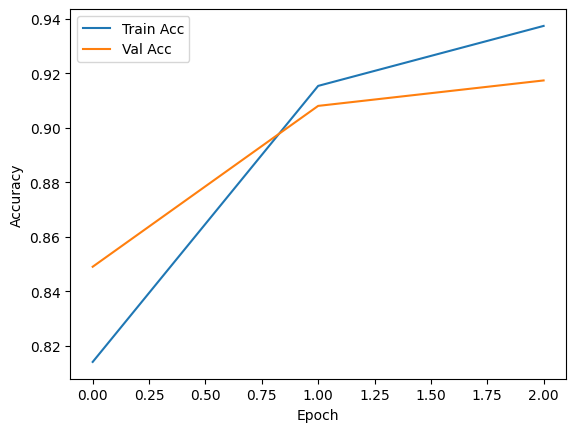

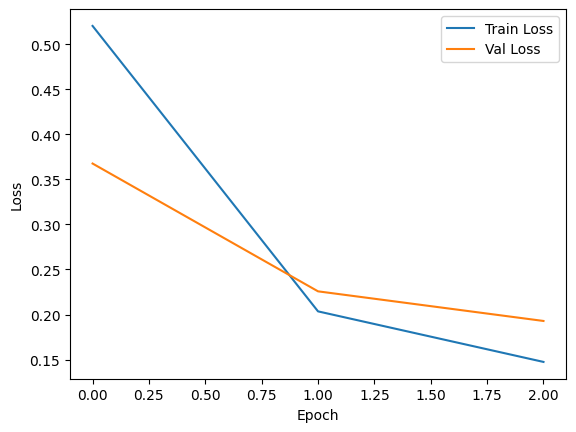

In [11]:
plot_accuracy(history).show()
plot_loss(history).show()

## Seeing the Results

In [12]:
import random
import matplotlib.pyplot as plt

def show_predictions(model, dataset, device, idx_to_class, num_images=8):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, label = dataset[idx]
            input_tensor = image.unsqueeze(0).to(device)  # [1, C, H, W]
            output = model(input_tensor)
            _, pred = torch.max(output, 1)

            img = image.permute(1, 2, 0).cpu() * 0.5 + 0.5  # unnormalize

            plt.subplot(2, (num_images+1)//2, i+1)
            plt.imshow(img)
            plt.title(f"Actual: {idx_to_class[label]}\nPred: {idx_to_class[pred.item()]}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

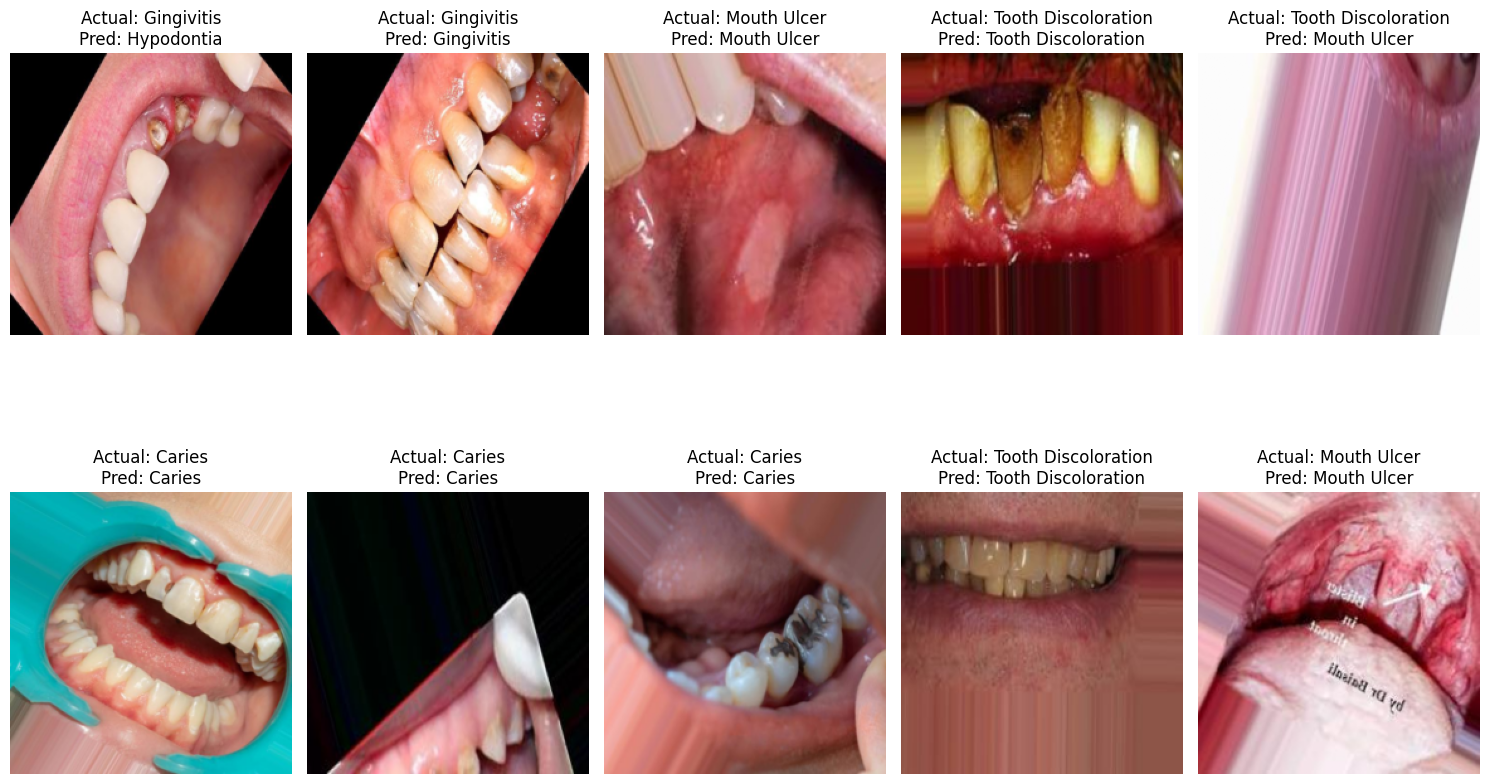

In [13]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
show_predictions(model, val_dataset, device, idx_to_class, num_images=10)

## Seeing the model

In [14]:
torch.save(model, 'Pre-Trained_ViT.pkl')